In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random
from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from transformers import Dinov2Model

device = torch.device('mps')


/Users/k.choi/opt/miniconda3/envs/pytorch_csiro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_dir     = '/Users/k.choi/Documents/github/csiro_git'
data_dir        = os.path.join(project_dir, 'data')
model_dir       = os.path.join(project_dir, 'models'); os.makedirs(model_dir, exist_ok=True)

csv_data        = pd.read_csv(os.path.join(data_dir, 'train.csv'))
target_names    = csv_data['target_name'].unique()

In [3]:
def preprocess_data(df, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
    unqiue_path = df['image_path'].unique()
    data_list = []
    for uni_path in unqiue_path:

        data = df[df['image_path'] == uni_path]
        row   = {'image_path': uni_path} 

        for tar in target_names: 
            row[tar] = data[data['target_name'] == tar]['target'].values[0]
            
        data_list.append(row)   

    return pd.DataFrame(data_list)

In [4]:
data = preprocess_data(csv_data)

train_data, valid_data = train_test_split(data, test_size=0.2, random_state=8964)
train_data, test_data  = train_test_split(train_data, test_size=0.01, random_state=8964)

print(f"train data: {len(train_data)}")
print(f"valid data: {len(valid_data)}")
print(f"test data: {len(test_data)}")


train data: 282
valid data: 72
test data: 3


In [5]:
class BiomassDS(Dataset):
    def __init__(self, df, data_dir, transform, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        self.target_names = target_names

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        targets = torch.tensor([row[col] for col in self.target_names], dtype=torch.float32)
        return image, targets


In [6]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

batch_size = 16 
WORKERS = 0

class rand_rota:
    def __call__(self, img):
        angle = np.random.choice([0,90,180,270])
        return transforms.functional.rotate(img, int(angle))

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    rand_rota(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_ds = BiomassDS(df =train_data, data_dir=data_dir, transform=train_transform)
valid_ds = BiomassDS(df =valid_data, data_dir=data_dir, transform=valid_transform)
test_ds  = BiomassDS(df =test_data,  data_dir=data_dir, transform=valid_transform)

assert len(train_ds) == len(train_data) and len(valid_ds) == len(valid_data)

train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=WORKERS, shuffle=True  , pin_memory=False)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=WORKERS, shuffle=False , pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, num_workers=WORKERS, shuffle=False , pin_memory=False)

sample_img, sample_target = train_ds[0]
assert sample_img.shape == (3, 224, 224) and sample_target.shape == (5,)
sample_img, sample_target = valid_ds[0]
assert sample_img.shape == (3, 224, 224) and sample_target.shape == (5,)
sample_img, sample_target = test_ds[0]
assert sample_img.shape == (3, 224, 224) and sample_target.shape == (5,)


In [7]:
class get_smalldino(nn.Module):

    def __init__(self, backbone, patch_dim = 384, num_targets = 5):
        super().__init__()
        self.backbone = backbone  

        for params in self.backbone.parameters():
            params.requires_grad = False

        self.heads = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_targets)
        )

    def forward(self, x):

        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :] ### (batch_size, 256, 384)
        
        batch_size, num_patches, patch_dim = patch_features.shape 
        patch_features_flat = patch_features.reshape(-1, patch_dim) ### (batch_size * num_patches, 384)
        patch_preds = self.heads(patch_features_flat) ### (batch_size * num_patches, num_targets)
        patch_preds = patch_preds.reshape(batch_size, num_patches, -1)  ### (batch_size, num_patches, num_targets)

        avg_pred = torch.mean(patch_preds, dim=1) ### (batch_size, num_targets)
        return avg_pred, patch_preds


In [8]:
class get_basedino(nn.Module):

    def __init__(self, backbone, patch_dim = 768, num_targets = 5):
        super().__init__()
        self.backbone = backbone  

        for params in self.backbone.parameters():
            params.requires_grad = False

        self.heads = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_targets)
        )

    def forward(self, x):

        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :] ### (batch_size, 256, 384)
        
        batch_size, num_patches, patch_dim = patch_features.shape 
        patch_features_flat = patch_features.reshape(-1, patch_dim) ### (batch_size * num_patches, 384)
        patch_preds = self.heads(patch_features_flat) ### (batch_size * num_patches, num_targets)
        patch_preds = patch_preds.reshape(batch_size, num_patches, -1)  ### (batch_size, num_patches, num_targets)

        avg_pred = torch.mean(patch_preds, dim=1) ### (batch_size, num_targets)
        return avg_pred, patch_preds


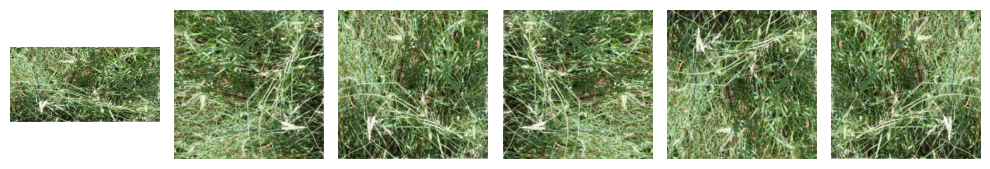

In [9]:
fig, axes = plt.subplots(1,6, figsize=(10,3))
img0 = Image.open(os.path.join(data_dir, random.choice( train_data['image_path'].unique())))

for i, ax in enumerate(axes):
    if i ==0: 
        ax.imshow(img0)
        ax.axis('off')
        continue

    img = train_transform(img0)
    mean = torch.tensor( [0.485, 0.456, 0.406] ).view(3,1,1)
    std  = torch.tensor( [0.229, 0.224, 0.225] ).view(3,1,1)
    img = img * std + mean
    img = img.clamp(0,1).permute(1,2,0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout();plt.show()

In [10]:
class get_largedino(nn.Module):

    def __init__(self, backbone, patch_dim = 1024, num_targets = 5):
        super().__init__()
        self.backbone = backbone  

        for params in self.backbone.parameters():
            params.requires_grad = False

        self.heads = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_targets)
        )

    def forward(self, x):

        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :] ### (batch_size, 256, 384)
        
        batch_size, num_patches, patch_dim = patch_features.shape 
        patch_features_flat = patch_features.reshape(-1, patch_dim) ### (batch_size * num_patches, 384)
        patch_preds = self.heads(patch_features_flat) ### (batch_size * num_patches, num_targets)
        patch_preds = patch_preds.reshape(batch_size, num_patches, -1)  ### (batch_size, num_patches, num_targets)

        avg_pred = torch.mean(patch_preds, dim=1) ### (batch_size, num_targets)
        return avg_pred, patch_preds


In [11]:
dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-small')
# dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-base')
# dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-large')
dinov2_backbone.eval()
dinov2_backbone.to(device)

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06,

In [12]:
# model = get_smalldino(dinov2_backbone, patch_dim=384, num_targets=5)
# model = get_basedino(dinov2_backbone, patch_dim=768, num_targets=5)
model = get_largedino(dinov2_backbone, patch_dim=384, num_targets=5)
model.to(device)

all_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {all_params}")
train_params = sum(p.numel() for p in model.heads.parameters())
print(f"Trainable parameters: {train_params}")
frozen_params = sum(p.numel() for p in model.backbone.parameters())
print(f"Frozen parameters: {frozen_params}")


Total parameters: 22387845
Trainable parameters: 331269
Frozen parameters: 22056576


In [13]:
LR = 1e-3 
WEIGHT_DECAY = 1e-4 
EARLY_STOPPING_PATIENCE = 10
LR_PATIENCE = 5


optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience= LR_PATIENCE)
criterion = nn.MSELoss()

In [14]:
from sklearn.metrics import mean_squared_error

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()

    total_loss = 0
    num_batches = 0

    pbar = tqdm(loader, desc='Training')

    for img, tar in pbar:
        img = img.to(device)
        tar = tar.to(device)

        optimizer.zero_grad()

        pred, _ = model(img)
        loss = criterion(pred, tar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    return avg_loss

def validate_epoch(model, loader, criterion, device):
    model.eval()

    total_loss = 0
    num_batches = 0
    
    all_preds = []
    all_targs = []

    with torch.no_grad():

        pbar = tqdm(loader, desc='Validation')
        for img, tar in pbar:
            img = img.to(device)
            tar = tar.to(device)

            pred, _ = model(img)
            loss = criterion(pred, tar)

            total_loss += loss.item()
            num_batches += 1

            all_preds.append(pred.cpu())
            all_targs.append(tar.cpu())

    avg_loss  = total_loss / num_batches
    all_preds = torch.cat(all_preds).numpy()
    all_targs = torch.cat(all_targs).numpy()

    mse  = mean_squared_error(all_targs, all_preds)
    rmse = np.sqrt(mse)
    
    return avg_loss, rmse, all_preds, all_targs
            
    

In [15]:
NUM_EPOCHS = 100

epoch_counts = 0
best_val = float('inf')
best_model = None

history = {'train_loss': [], 'valid_loss': [], 'val_rmse': [], 'pre_target_rmse': [], 'learning_rate': []}
for epoch in range(NUM_EPOCHS):

    train_loss                              = train_epoch(model, train_loader, optimizer, criterion, device)
    valid_loss, rmse, all_preds, all_targs  = validate_epoch(model, valid_loader, criterion, device)

    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']

    """ update history """
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['val_rmse'].append(rmse)
    history['learning_rate'].append(current_lr)

    pre_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
    history['pre_target_rmse'].append(pre_target_rmse)

    print(f"epoch: {epoch}/{NUM_EPOCHS}")
    print(32 * " -")
    print(f"  train loss: {train_loss:.1f}")
    print(f"  valid loss: {valid_loss:.1f}")
    print(f"  rmse: {rmse:.1f}") 
    print(f"  lr: {current_lr:.6f}")
    per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
    print(f"  per target rmse: {per_target_rmse}")

    if valid_loss < best_val:
        print(f"val_loss improved from {best_val:.4f} to {valid_loss:.4f}")
        best_val = valid_loss
        epoch_counter = 0
        torch.save(model.state_dict(), os.path.join(model_dir, f'best_model_dinov2_small.pth'))
        best_model = model.state_dict()
        print(f"best model saved")

    else:
        epoch_counter += 1
        print(f"no val_loss improvement from {best_val:.4f}")

    
    if epoch_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


epoch: 0/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1170.5
  valid loss: 899.1
  rmse: 30.5
  lr: 0.001000
  per target rmse: [ 8.37027  18.754658 30.07045  47.54307  32.849216]
val_loss improved from inf to 899.0516
best model saved


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


epoch: 1/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1046.7
  valid loss: 799.3
  rmse: 28.8
  lr: 0.001000
  per target rmse: [ 7.80832  17.324207 28.419521 45.175587 30.798304]
val_loss improved from 899.0516 to 799.3294
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


epoch: 2/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 938.6
  valid loss: 707.2
  rmse: 27.2
  lr: 0.001000
  per target rmse: [ 7.7844877 16.251814  26.64812   42.75676   28.743551 ]
val_loss improved from 799.3294 to 707.2216
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


epoch: 3/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 855.0
  valid loss: 625.0
  rmse: 25.6
  lr: 0.001000
  per target rmse: [ 7.919474 15.51505  25.098314 40.26666  26.744774]
val_loss improved from 707.2216 to 625.0162
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


epoch: 4/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 760.0
  valid loss: 557.4
  rmse: 24.2
  lr: 0.001000
  per target rmse: [ 8.054865 15.100448 23.780508 37.927864 25.058313]
val_loss improved from 625.0162 to 557.4295
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


epoch: 5/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 711.8
  valid loss: 500.0
  rmse: 22.9
  lr: 0.001000
  per target rmse: [ 8.068711 14.922067 22.73949  35.65668  23.565737]
val_loss improved from 557.4295 to 500.0361
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


epoch: 6/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 640.8
  valid loss: 453.2
  rmse: 21.9
  lr: 0.001000
  per target rmse: [ 8.019984 14.827637 21.752968 33.69742  22.38679 ]
val_loss improved from 500.0361 to 453.1869
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


epoch: 7/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 596.6
  valid loss: 407.8
  rmse: 20.8
  lr: 0.001000
  per target rmse: [ 7.9094925 14.633644  20.764622  31.794909  21.247692 ]
val_loss improved from 453.1869 to 407.8270
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


epoch: 8/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 538.5
  valid loss: 371.3
  rmse: 19.9
  lr: 0.001000
  per target rmse: [ 7.7768507 14.710756  19.475239  30.508793  19.965652 ]
val_loss improved from 407.8270 to 371.2628
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


epoch: 9/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 491.8
  valid loss: 342.1
  rmse: 19.2
  lr: 0.001000
  per target rmse: [ 7.7105126 14.590431  18.79482   29.059647  19.140493 ]
val_loss improved from 371.2628 to 342.0525
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


epoch: 10/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 456.7
  valid loss: 315.2
  rmse: 18.4
  lr: 0.001000
  per target rmse: [ 7.5466213 14.39844   18.443644  27.424116  18.458517 ]
val_loss improved from 342.0525 to 315.1704
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


epoch: 11/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 415.4
  valid loss: 290.7
  rmse: 17.7
  lr: 0.001000
  per target rmse: [ 7.326957 14.311025 17.608578 26.352388 17.533152]
val_loss improved from 315.1704 to 290.7060
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


epoch: 12/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 400.0
  valid loss: 276.1
  rmse: 17.3
  lr: 0.001000
  per target rmse: [ 7.183375 14.183983 17.271498 25.350914 17.30914 ]
val_loss improved from 290.7060 to 276.1179
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch: 13/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 360.8
  valid loss: 260.8
  rmse: 16.8
  lr: 0.001000
  per target rmse: [ 6.903204 14.322772 16.311216 25.19115  16.062922]
val_loss improved from 276.1179 to 260.8250
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


epoch: 14/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 339.1
  valid loss: 242.7
  rmse: 16.2
  lr: 0.001000
  per target rmse: [ 7.011924 14.147108 15.820962 23.989681 15.508024]
val_loss improved from 260.8250 to 242.7004
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


epoch: 15/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 317.6
  valid loss: 270.6
  rmse: 17.0
  lr: 0.001000
  per target rmse: [ 6.612696 14.299198 16.462992 25.515572 16.464104]
no val_loss improvement from 242.7004


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


epoch: 16/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 303.4
  valid loss: 222.2
  rmse: 15.5
  lr: 0.001000
  per target rmse: [ 6.618578 14.083959 15.047319 22.858273 14.560626]
val_loss improved from 242.7004 to 222.1582
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


epoch: 17/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 281.5
  valid loss: 206.5
  rmse: 14.9
  lr: 0.001000
  per target rmse: [ 6.7651944 13.918612  14.355534  21.935759  13.715567 ]
val_loss improved from 222.1582 to 206.5180
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


epoch: 18/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 267.1
  valid loss: 197.1
  rmse: 14.6
  lr: 0.001000
  per target rmse: [ 6.361678 13.763383 13.798854 21.777185 13.058696]
val_loss improved from 206.5180 to 197.0675
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


epoch: 19/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 251.7
  valid loss: 183.8
  rmse: 14.1
  lr: 0.001000
  per target rmse: [ 6.167882 13.455458 13.613388 20.512484 13.191635]
val_loss improved from 197.0675 to 183.8184
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


epoch: 20/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 235.4
  valid loss: 172.2
  rmse: 13.7
  lr: 0.001000
  per target rmse: [ 6.2298036 13.36068   12.599202  20.42489   11.920876 ]
val_loss improved from 183.8184 to 172.2142
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


epoch: 21/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 227.8
  valid loss: 172.1
  rmse: 13.7
  lr: 0.001000
  per target rmse: [ 6.1073565 13.340712  12.714728  20.446068  11.886203 ]
val_loss improved from 172.2142 to 172.0656
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


epoch: 22/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 215.1
  valid loss: 158.8
  rmse: 13.1
  lr: 0.001000
  per target rmse: [ 6.082866 13.012344 12.147414 19.490955 11.432369]
val_loss improved from 172.0656 to 158.7627
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


epoch: 23/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 198.7
  valid loss: 152.8
  rmse: 12.9
  lr: 0.001000
  per target rmse: [ 6.000395 13.080765 11.79344  19.16277  10.798623]
val_loss improved from 158.7627 to 152.7731
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


epoch: 24/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 197.0
  valid loss: 150.6
  rmse: 12.8
  lr: 0.001000
  per target rmse: [ 5.9788876 12.981558  11.686576  18.847324  11.129492 ]
val_loss improved from 152.7731 to 150.6448
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


epoch: 25/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 192.3
  valid loss: 142.7
  rmse: 12.5
  lr: 0.001000
  per target rmse: [ 5.7708354 13.28109   10.716677  18.519196  10.44929  ]
val_loss improved from 150.6448 to 142.7271
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


epoch: 26/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 170.3
  valid loss: 133.8
  rmse: 12.0
  lr: 0.001000
  per target rmse: [ 5.248605 13.203142 10.547478 17.70378   9.898309]
val_loss improved from 142.7271 to 133.8150
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


epoch: 27/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 165.7
  valid loss: 134.5
  rmse: 12.1
  lr: 0.001000
  per target rmse: [ 5.2102914 13.389227  10.642156  17.545958  10.23098  ]
no val_loss improvement from 133.8150


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


epoch: 28/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 159.7
  valid loss: 127.2
  rmse: 11.8
  lr: 0.001000
  per target rmse: [ 4.8001795 12.84343   10.216225  17.430384   9.716151 ]
val_loss improved from 133.8150 to 127.1676
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


epoch: 29/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 145.4
  valid loss: 122.8
  rmse: 11.5
  lr: 0.001000
  per target rmse: [ 4.8409014 12.652778  10.050826  16.784517   9.657541 ]
val_loss improved from 127.1676 to 122.8189
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


epoch: 30/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 144.1
  valid loss: 123.7
  rmse: 11.6
  lr: 0.001000
  per target rmse: [ 4.8010626 12.84794   10.319714  16.739681   9.783437 ]
no val_loss improvement from 122.8189


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


epoch: 31/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 149.7
  valid loss: 123.8
  rmse: 11.5
  lr: 0.001000
  per target rmse: [ 4.46322  13.157328 10.045546 16.63635   9.633425]
no val_loss improvement from 122.8189


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


epoch: 32/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 128.7
  valid loss: 122.6
  rmse: 11.5
  lr: 0.001000
  per target rmse: [ 4.470443 12.879062  9.787333 17.055248  9.442742]
val_loss improved from 122.8189 to 122.5853
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


epoch: 33/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 124.5
  valid loss: 117.9
  rmse: 11.3
  lr: 0.001000
  per target rmse: [ 4.6839876 12.451354  10.195317  16.084074   9.685853 ]
val_loss improved from 122.5853 to 117.9377
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


epoch: 34/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 116.2
  valid loss: 120.8
  rmse: 11.4
  lr: 0.001000
  per target rmse: [ 4.742437 12.801813  9.95735  16.694447  9.385877]
no val_loss improvement from 117.9377


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


epoch: 35/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 114.4
  valid loss: 114.7
  rmse: 11.2
  lr: 0.001000
  per target rmse: [ 4.338227 12.395346  9.959646 15.972168  9.765664]
val_loss improved from 117.9377 to 114.6580
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


epoch: 36/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 105.9
  valid loss: 112.6
  rmse: 11.0
  lr: 0.001000
  per target rmse: [ 4.792118 12.284937  9.680629 15.804665  9.406377]
val_loss improved from 114.6580 to 112.5814
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


epoch: 37/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 106.3
  valid loss: 157.0
  rmse: 12.9
  lr: 0.001000
  per target rmse: [ 5.3132215 12.261548  11.777926  18.97077   12.617598 ]
no val_loss improvement from 112.5814


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


epoch: 38/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 110.5
  valid loss: 110.0
  rmse: 10.9
  lr: 0.001000
  per target rmse: [ 4.9529862 12.184703   9.642644  15.507096   9.560228 ]
val_loss improved from 112.5814 to 110.0415
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


epoch: 39/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 104.2
  valid loss: 129.5
  rmse: 11.7
  lr: 0.001000
  per target rmse: [ 4.5390277 13.049566   9.967864  17.274588   9.78125  ]
no val_loss improvement from 110.0415


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


epoch: 40/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 96.3
  valid loss: 104.0
  rmse: 10.6
  lr: 0.001000
  per target rmse: [ 4.565813 13.017466  8.830878 14.951102  8.578679]
val_loss improved from 110.0415 to 104.0008
best model saved


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


epoch: 41/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 94.9
  valid loss: 135.0
  rmse: 12.0
  lr: 0.001000
  per target rmse: [ 4.6245675 13.100313  10.874428  17.4318    10.308308 ]
no val_loss improvement from 104.0008


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


epoch: 42/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 89.7
  valid loss: 114.9
  rmse: 11.1
  lr: 0.001000
  per target rmse: [ 4.649857  12.536371  10.2002945 15.485205   9.760871 ]
no val_loss improvement from 104.0008


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


epoch: 43/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 80.6
  valid loss: 126.1
  rmse: 11.7
  lr: 0.001000
  per target rmse: [ 4.958858 12.749138 10.375559 17.093056  9.623729]
no val_loss improvement from 104.0008


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


epoch: 44/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 75.0
  valid loss: 111.3
  rmse: 10.9
  lr: 0.001000
  per target rmse: [ 4.5278406 12.841905   9.21977   15.712296   8.941725 ]
no val_loss improvement from 104.0008


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


epoch: 45/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 73.5
  valid loss: 115.8
  rmse: 11.1
  lr: 0.001000
  per target rmse: [ 4.796524 13.03243   9.364485 16.196478  8.715879]
no val_loss improvement from 104.0008


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


epoch: 46/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 74.1
  valid loss: 111.1
  rmse: 10.9
  lr: 0.000500
  per target rmse: [ 4.386794  12.781787   9.468152  15.4854965  9.019346 ]
no val_loss improvement from 104.0008


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


epoch: 47/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 64.6
  valid loss: 121.0
  rmse: 11.3
  lr: 0.000500
  per target rmse: [ 4.69542  12.32302  10.068844 16.613802  9.531758]
no val_loss improvement from 104.0008


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch: 48/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 62.8
  valid loss: 107.8
  rmse: 10.7
  lr: 0.000500
  per target rmse: [ 4.5891943 11.976237   9.460684  15.398591   8.951618 ]
no val_loss improvement from 104.0008


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


epoch: 49/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 61.6
  valid loss: 109.9
  rmse: 10.9
  lr: 0.000500
  per target rmse: [ 4.568977 12.534454  9.857129 15.223641  9.121008]
no val_loss improvement from 104.0008


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

epoch: 50/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 60.7
  valid loss: 109.8
  rmse: 10.8
  lr: 0.000500
  per target rmse: [ 4.580653 12.399659  9.614572 15.387685  9.000071]
no val_loss improvement from 104.0008
Early stopping at epoch 51


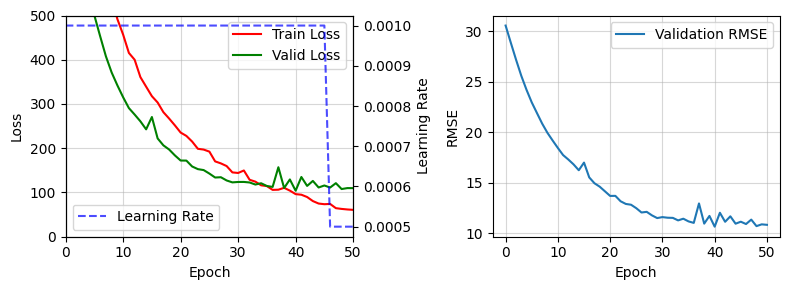

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

axes[0].plot(history['train_loss'], label='Train Loss', c='r')
axes[0].plot(history['valid_loss'], label='Valid Loss', c='g')
axes[0].legend(loc = 'upper right')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim(0, 50)
axes[0].set_ylim(0, 500)

ax1 = axes[0].twinx()
ax1.plot(history['learning_rate'], label='Learning Rate', c='b', ls='--', alpha=0.7)
ax1.set_ylabel('Learning Rate')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower left')

axes[1].plot(history['val_rmse'], label='Validation RMSE')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Epoch')
axes[0].grid(True,alpha=0.5)
axes[1].grid(True,alpha=0.5)

plt.tight_layout()
plt.show()


In [18]:
data.describe()

,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,6.649692,12.044548,26.624722,45.318097,33.274414
std,12.117761,12.402007,25.401232,27.984015,24.935822
min,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.000000,3.200000,8.800000,25.271500,16.026100
50%,1.423500,7.980900,20.800000,40.300000,27.108200
75%,7.242900,17.637800,35.083400,57.880000,43.675700
max,71.786500,83.840700,157.983600,185.700000,157.983600


In [19]:
history_pd = pd.DataFrame(history)
history_pd.to_csv(os.path.join(model_dir, 'history_dinov2_small.csv'), index=False)

In [20]:
display(history_pd)

,train_loss,valid_loss,val_rmse,pre_target_rmse,learning_rate
0,1170.476488,899.051550,30.546506,"[8.37027, 18.754658, 30.07045, 47.54307, 32.84...",0.0010
1,1046.697883,799.329437,28.837949,"[7.80832, 17.324207, 28.419521, 45.175587, 30....",0.0010
2,938.560486,707.221552,27.163115,"[7.7844877, 16.251814, 26.64812, 42.75676, 28....",0.0010
3,854.962309,625.016199,25.573607,"[7.919474, 15.51505, 25.098314, 40.26666, 26.7...",0.0010
4,759.979922,557.429547,24.186190,"[8.054865, 15.100448, 23.780508, 37.927864, 25...",0.0010
5,711.820158,500.036072,22.941663,"[8.068711, 14.922067, 22.73949, 35.65668, 23.5...",0.0010
6,640.760717,453.186926,21.881749,"[8.019984, 14.827637, 21.752968, 33.69742, 22....",0.0010
7,596.569529,407.826956,20.833885,"[7.9094925, 14.633644, 20.764622, 31.794909, 2...",0.0010
8,538.532071,371.262808,19.927792,"[7.7768507, 14.710756, 19.475239, 30.508793, 1...",0.0010
9,491.839918,342.052496,19.164548,"[7.7105126, 14.590431, 18.79482, 29.059647, 19...",0.0010


In [21]:
best_model = torch.load(os.path.join(model_dir, 'best_model_dinov2_small.pth'))
model.load_state_dict(best_model)
model.eval()

test_loss, test_rmse, all_test_preds, all_test_targs  = validate_epoch(model, test_loader, criterion, device)

Validation: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


In [22]:
print(f"test loss: {test_loss:.1f}")
print(f"test rmse: {test_rmse:.1f}")
print(f"test per target rmse: {np.sqrt(np.mean((all_test_preds - all_test_targs)**2, axis=0))}")

test loss: 103.9
test rmse: 10.2
test per target rmse: [ 2.9716609  5.2155485 13.12905    9.964681  14.552074 ]


In [23]:
len(test_data)

3

In [24]:
for targets in target_names[:1]:
    print(test_data[targets].values)

[4.0923 0.     1.1385]


In [25]:
all_test_preds.shape

(3, 5)

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

for i , tar in enumerate(target_names):

    true_target = test_data[tar].values
    pred_target = all_test_preds[:, i]

    mse = mean_squared_error(true_target, pred_target) 
    rmse = np.sqrt(mse)
    # r2 = r2_score(true_target, pred_target)
    mae = mean_absolute_error(true_target, pred_target)
    print(f"-- target: {tar}")
    print(f" mean: {np.mean(true_target):.2f}")
    print(f" rmse: {rmse:.2f}")
    # print(f" r2: {r2:.2f}")
    print(f" mae: {mae:.2f}")

-- target: Dry_Clover_g
 mean: 1.74
 rmse: 2.97
 mae: 2.52
-- target: Dry_Dead_g
 mean: 16.30
 rmse: 5.22
 mae: 4.45
-- target: Dry_Green_g
 mean: 13.24
 rmse: 13.13
 mae: 12.51
-- target: Dry_Total_g
 mean: 31.29
 rmse: 9.96
 mae: 8.99
-- target: GDM_g
 mean: 14.99
 rmse: 14.55
 mae: 13.16
